# Workspace \#10: Parameter Space

In [1]:
# getting future division
from __future__ import division

# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d, interp2d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import ticker
from matplotlib.lines import Line2D

# other
import os
import itertools
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random, choice

import sys
sys.path.insert(0, '../')

import tools as tl
import constants as ct
import particle as pt
import ska as sk
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md
import green as gr

In [3]:
# Important quantities for aberration estimate
solar_period = 2.4e8 # [years]
solar_mw_radius = ct._Sun_to_gal_center_ # [kpc]

## 1. Loading other axion limits

In [4]:
sys.path.insert(0, '../axion_limits/')
from PlotFuncs_mod import gen_constraints

(<Figure size 648x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4b9a34eed0>)

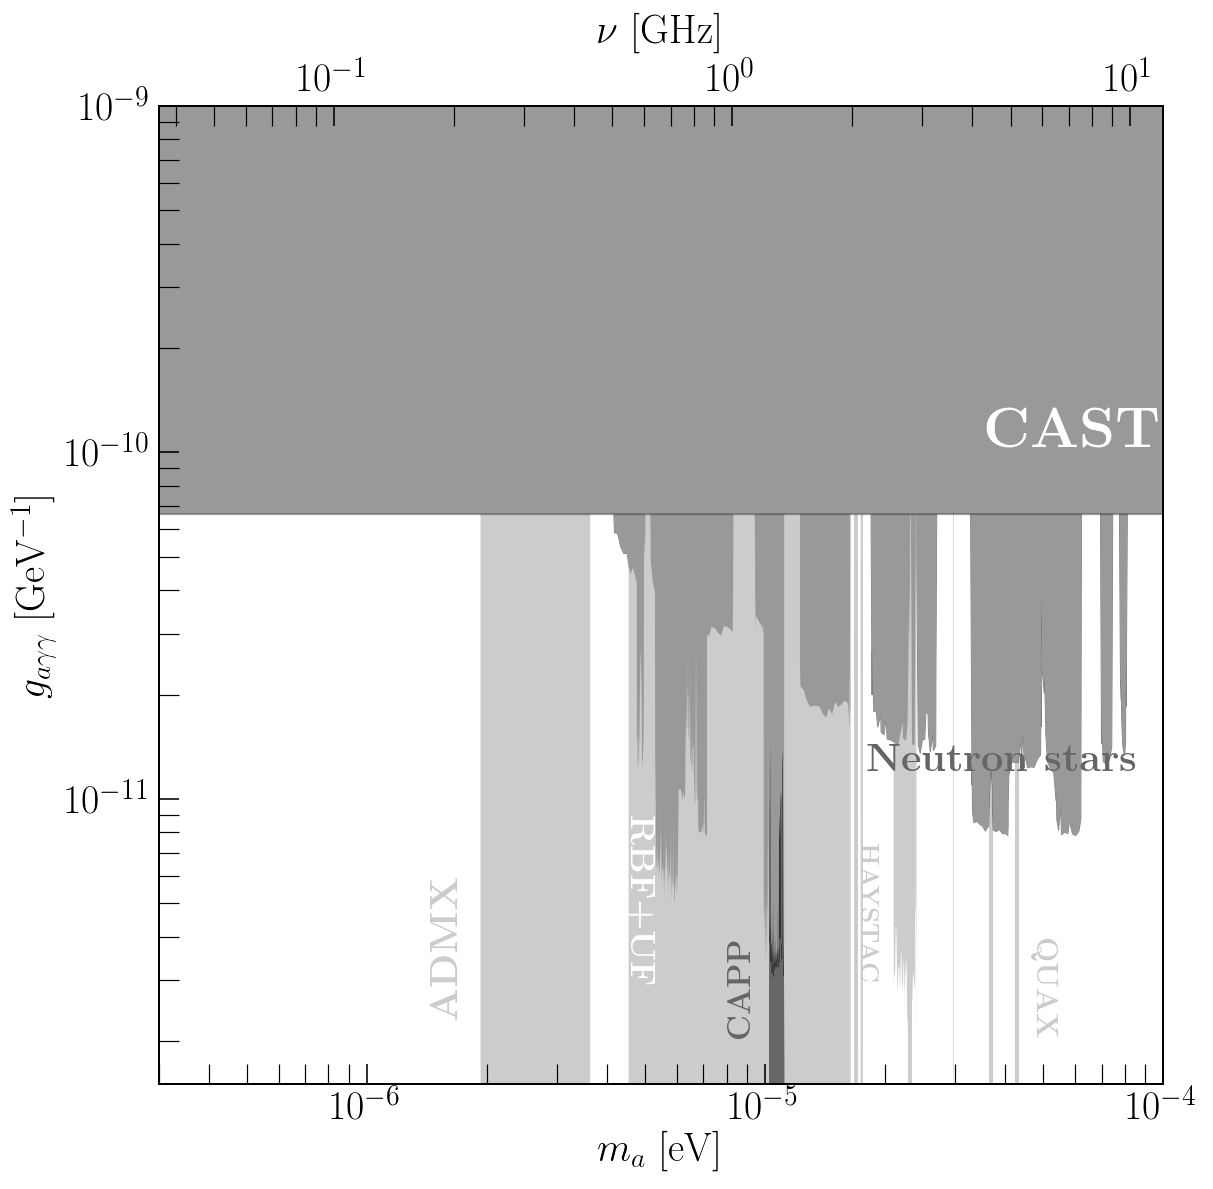

In [5]:
gen_constraints()

## 2. Loading Green's Catalog Results

#### N.B.: Full results data available upon request. You can also compute them yourself with ``run_green.py``.

In [6]:
CasA = 'G111.7-2.1'
W28 = 'G6.4-0.1'
W50 = 'G39.7-2.0'
Kepler = 'G4.5+6.8'
Crab = 'G184.6−5.8'
Vela = 'G263.9−3.3'
SgrAEast = 'G0.0+0.0'

In [7]:
help(gr.load_green_results)

Help on function load_green_results in module green:

load_green_results(name, run_id=None)
    Function that loads the numerical results for the SNRs from Green's Catalog.



### 2.1 $(m_a, g_{a\gamma\gamma})$

In [8]:
ma_ga_reach = {}
for run_id in tqdm(range(1,13)):
    
    ma_ga_reach[run_id] = {}
    
    for name in dt.snrs_cut.keys():
    # NOTE: SPEED UP!
        if name != 'G39.7-2.0':
            continue
    # NOTE: SPEED UP!
        
        try:
            _, ma, res = gr.load_green_results(name, run_id=run_id)
        except:
            continue
        
        ma_ga_reach[run_id][name] = np.vstack((ma, res['ga'])).T


# repeating the process, but for some special runs
for run_id in tqdm([101, 102]):
    
    ma_ga_reach[run_id] = {}
    
    for name in dt.snrs_cut.keys():
    # NOTE: SPEED UP!
        if name != 'G39.7-2.0':
            continue
    # NOTE: SPEED UP!
        
        try:
            _, ma, res = gr.load_green_results(name, run_id=run_id)
        except:
            continue
        
        ma_ga_reach[run_id][name] = np.vstack((ma, res['ga'])).T

del run_id, name, ma, res

100%|██████████| 2/2 [00:00<00:00, 173.34it/s]


In [9]:
runs_mins = {}
for run_id in range(1, 13):
    reach = ma_ga_reach[run_id]
    try:
        tmp = {name:min(maga[:,1]) for name, maga in reach.items()}
        min_name = min(tmp, key=tmp.__getitem__)
        runs_mins[run_id] = min_name, min(reach[min_name][:,1])
    except:
        continue

del run_id, reach, tmp, min_name

In [10]:
# runs_mins

### 2.2 $(L_{\rm pk}, t_{\rm pk})$

Not necessary, not in the paper.

### 2.3 $(t_{\rm trans}, t_{\rm pk})$

In [11]:
ttr_tpk_reach = {}
for run_id in tqdm(range(19,25)):
    
    ttr_tpk_reach[run_id] = {}
    
    for name in dt.snrs_cut.keys():
    # NOTE: SPEED UP!
        if name != 'G39.7-2.0':
            continue
    # NOTE: SPEED UP!
        
        try:
            _, pars, res = gr.load_green_results(name, run_id=run_id)
        except:
            continue
        
        ttr, tpk = pars
        
        ttr_tpk_reach[run_id][name] = (ttr, tpk, res['ga'], res['Lpk'])

del run_id, name, pars, res, ttr, tpk

100%|██████████| 6/6 [00:00<00:00, 19.91it/s]


## 3. Plots

In [12]:
def float_exp(num):
    
    dex = int(np.floor(log10(num)))
    lead = 10.**(log10(num)-dex)
    
    if lead == 1.:
        return r"$10^{%d}$" % dex
    else:
        return r"$%.0f \times 10^{%d}$" % (lead, dex)
    
    return lead, dex

In [13]:
gr.load_green_results(W50, run_id=4)[-1]

{'echo': array([2.03809235e-04, 1.90504014e-04, 1.78067394e-04, 1.66442670e-04,
        1.55576840e-04, 1.45420361e-04, 1.35926925e-04, 1.27053245e-04,
        1.18758864e-04, 1.11005963e-04, 1.03759192e-04, 9.69855094e-05,
        9.06540317e-05, 8.47358900e-05, 7.92041007e-05, 7.40334417e-05,
        6.92003374e-05, 6.46827512e-05, 6.04600853e-05, 5.65130866e-05,
        5.28237586e-05, 4.93752801e-05, 4.61519275e-05, 4.31390042e-05,
        4.03227728e-05, 3.76903925e-05, 3.52298612e-05, 3.29299601e-05,
        3.07802028e-05, 2.87707875e-05, 2.68925522e-05, 2.51369333e-05,
        2.34959260e-05, 2.19620480e-05, 2.05283058e-05, 1.91881622e-05,
        1.79355068e-05, 1.67646282e-05, 1.56701877e-05, 1.46471952e-05,
        1.36909865e-05, 1.27972017e-05, 1.19617655e-05, 1.11808690e-05,
        1.04509514e-05, 9.76868492e-06, 9.13095861e-06, 8.53486481e-06,
        7.97768563e-06, 6.99615097e-06, 6.13537944e-06, 5.38051294e-06,
        4.71852146e-06, 4.13797811e-06, 3.62886191e-06, 

### 3.1 $(m_a, g_{a\gamma\gamma})$

In [14]:
def ma_ga_arr(snr_name, sd_run, if_run):
    
    lines, ma, sd_res = gr.load_green_results(snr_name, run_id=sd_run)
    _, _, if_res = gr.load_green_results(snr_name, run_id=if_run)
    
    try:
        Lpk_idx = [('L_peak:' in line) for line in lines].index(True)
        Lpk = float(lines[Lpk_idx].split()[-1])
        
        tpk_idx = [('t_peak:' in line) for line in lines].index(True)
        tpk = float(lines[tpk_idx].split()[-1])
        
        extra = Lpk, tpk
        
    except:
        
        ttr_idx = [('t_trans:' in line) for line in lines].index(True)
        ttr = float(lines[ttr_idx].split()[-1])
    
        extra = ttr
    
    ma_ga = np.vstack((ma, np.minimum.reduce((sd_res['ga'], if_res['ga'])))).T
    
    return ma_ga, extra

In [15]:
ma_ga_arr(W50, 2, 8)

(array([[4.30321005e-07, 1.00422207e-10],
        [4.47753969e-07, 9.36772409e-11],
        [4.65893170e-07, 8.89244056e-11],
        [4.84767217e-07, 8.53597163e-11],
        [5.04405880e-07, 8.24344980e-11],
        [5.24840137e-07, 7.99262035e-11],
        [5.46102216e-07, 7.80397230e-11],
        [5.68225654e-07, 7.65784747e-11],
        [5.91245347e-07, 7.54742723e-11],
        [6.15197603e-07, 7.45961426e-11],
        [6.40120202e-07, 7.40662472e-11],
        [6.66052454e-07, 7.35709771e-11],
        [6.93035260e-07, 7.25906699e-11],
        [7.21111182e-07, 7.18610504e-11],
        [7.50324502e-07, 7.17444281e-11],
        [7.80721299e-07, 7.31069239e-11],
        [8.12349517e-07, 7.44322275e-11],
        [8.45259042e-07, 7.64862872e-11],
        [8.79501782e-07, 7.90041031e-11],
        [9.15131749e-07, 8.16209394e-11],
        [9.52205140e-07, 8.39789490e-11],
        [9.90780431e-07, 8.63547137e-11],
        [1.03091847e-06, 8.86729704e-11],
        [1.07268255e-06, 9.0757520

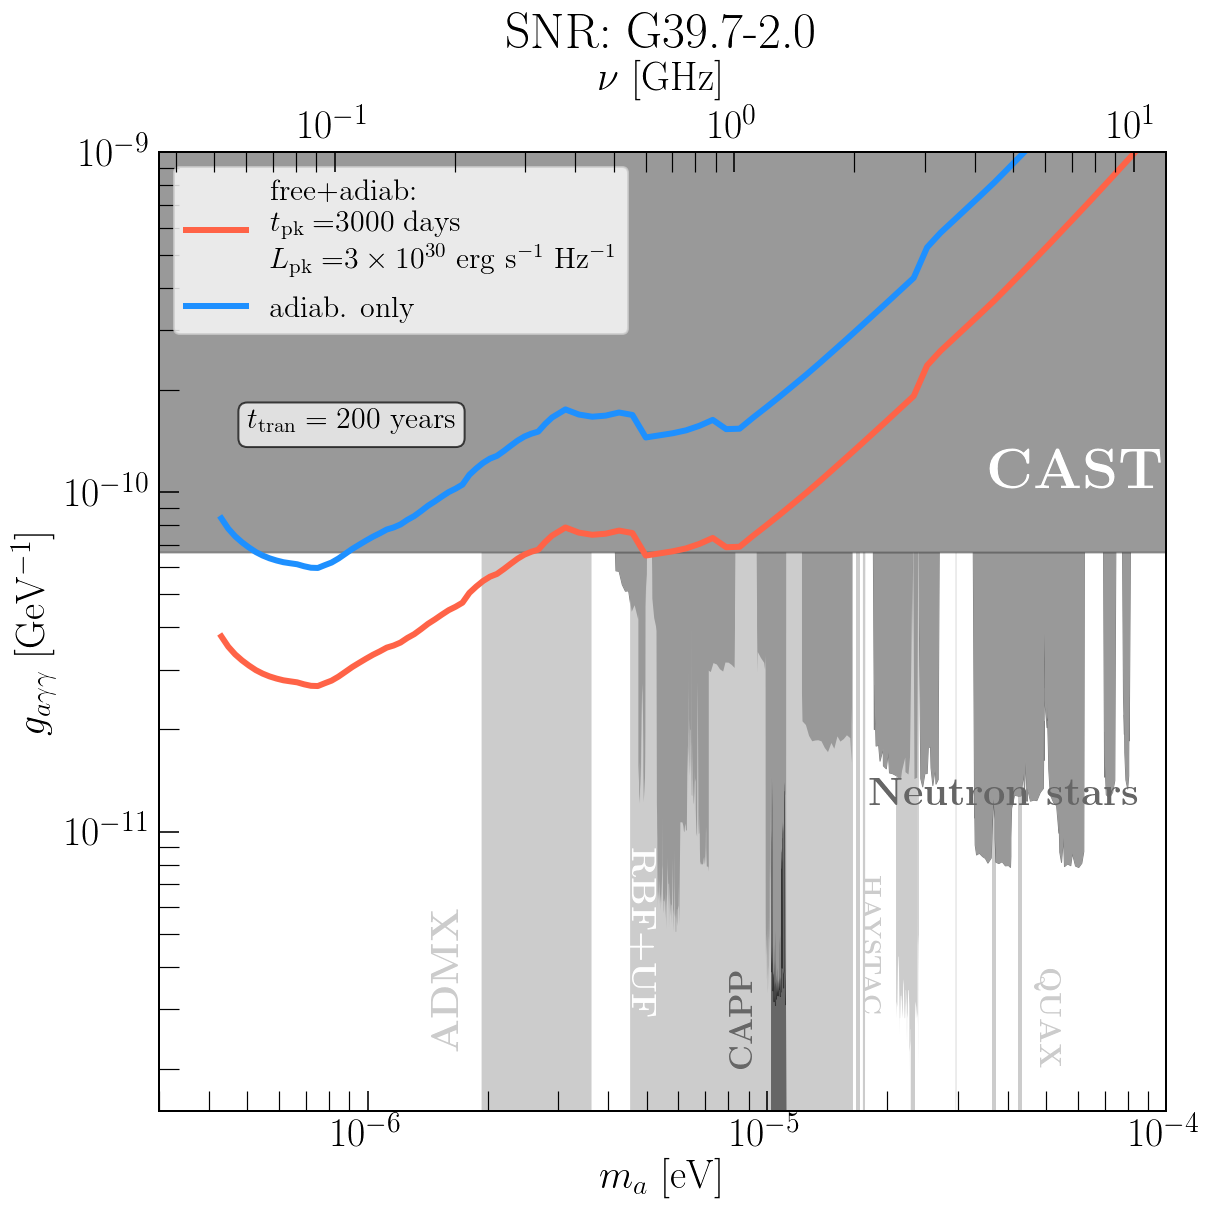

In [20]:
# whether we want to zoom the plot
zoomed = False

name = W50
# name = 'G119.5+10.2'
# name = 'G114.3+0.3'
# name = 'G65.3+5.7'

# runs for adiabatic only, t_trans = 300
# ad_sd_run, ad_if_run = 2, 8

# runs for adiabatic only, t_trans = 249
ad_sd_run, ad_if_run = 101, 102

# reach for adiabatic only:
ad_reach, ttr = ma_ga_arr(name, ad_sd_run, ad_if_run)

# runs for free+adiabatic, t_trans = 249
fa_sd_run, fa_if_run = 6, 12
# fa_sd_run, fa_if_run = 4, 10
fa_reach, pars = ma_ga_arr(name, fa_sd_run, fa_if_run)
Lpk, tpk = pars

fig, ax = gen_constraints()

lw = 3.

ax.loglog(fa_reach[:,0], fa_reach[:,1], lw=lw, color="tomato", label="free+adiab:\n"+r"$t_{\rm pk} = $"+"{} days".format(int(tpk))+"\n"+r"$L_{\rm pk} = $"+float_exp(Lpk)+r" $\mathrm{erg \ s^{-1} \ Hz^{-1}}$")

ax.loglog(ad_reach[:,0], ad_reach[:,1], lw=lw, color="dodgerblue", label="adiab. only")

if zoomed:
    ax.set_xlim(3.e-7, 1.e-4)
    ax.set_ylim(1.e-12, 1.e-9)

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(5.e-7, 1.5e-10, r"$t_{\rm tran} = %d$ years" % int(np.ceil(ttr/10)*10), fontsize=15, bbox=props)

ax.legend(fontsize=15, loc="best");
ax.set_title("SNR: %s" % name, fontsize=25);

plt.tight_layout()

file_name = "ma_ga_reach_%s.pdf" % name.replace(".", "")
plt.savefig("../plots/"+file_name, bbox_inches="tight")

### 3.2 $(L_{\rm pk}, t_{\rm pk})$

Not necessary, not in the paper.

### 3.3 $(t_{\rm trans}, t_{\rm pk})$

In [27]:
def ttr_tpk_results(snr_name, sd_run, if_run):
    
    lines, pars, sd_res = gr.load_green_results(snr_name, run_id=sd_run)
    _, _, if_res = gr.load_green_results(snr_name, run_id=if_run)
    
    ttr, tpk = pars
    # merging single-dish and interferometry
    ga_reach = np.minimum.reduce((sd_res['ga'], if_res['ga']))
    
    # Lpk conversion factor (pivot --> Bietenholz)
    alpha = dt.snrs_dct[snr_name].get_spectral_index()
    from_pivot_to_Bietenholz = (8./1.)**-alpha
    Lpk_Biet = sd_res['Lpk']*from_pivot_to_Bietenholz
    
    sigmas = (log10(Lpk_Biet) - ct._mu_log10_Lpk_)/ct._sig_log10_Lpk_
    
    return ttr, tpk, ga_reach, sd_res['Lpk'], sigmas

In [28]:
# sample result: t_trans, t_peak, ga_reach, L_peak, sigmas
ttr_tpk_results(W50, 19, 22)

(array([ 100.,  109.,  118.,  127.,  136.,  145.,  154.,  163.,  172.,
         181.,  190.,  199.,  208.,  217.,  226.,  235.,  244.,  253.,
         262.,  271.,  280.,  289.,  298.,  307.,  316.,  325.,  334.,
         343.,  352.,  361.,  370.,  379.,  388.,  397.,  406.,  415.,
         424.,  433.,  442.,  451.,  460.,  469.,  478.,  487.,  496.,
         505.,  514.,  523.,  532.,  541.,  550.,  559.,  568.,  577.,
         586.,  595.,  604.,  613.,  622.,  631.,  640.,  649.,  658.,
         667.,  676.,  685.,  694.,  703.,  712.,  721.,  730.,  739.,
         748.,  757.,  766.,  775.,  784.,  793.,  802.,  811.,  820.,
         829.,  838.,  847.,  856.,  865.,  874.,  883.,  892.,  901.,
         910.,  919.,  928.,  937.,  946.,  955.,  964.,  973.,  982.,
         991., 1000.]),
 array([1.00000000e-01, 1.13100714e-01, 1.27917715e-01, 1.44675849e-01,
        1.63629418e-01, 1.85066040e-01, 2.09311013e-01, 2.36732250e-01,
        2.67745865e-01, 3.02822485e-01, 3.42494392e

In [29]:
# best reaches for various runs:
print(ttr_tpk_results(W50, 19, 22)[2].min())
print(ttr_tpk_results(W50, 20, 23)[2].min())
print(ttr_tpk_results(W50, 21, 24)[2].min())

4.081039297439219e-12
1.957922734674024e-12
3.165861873689122e-11


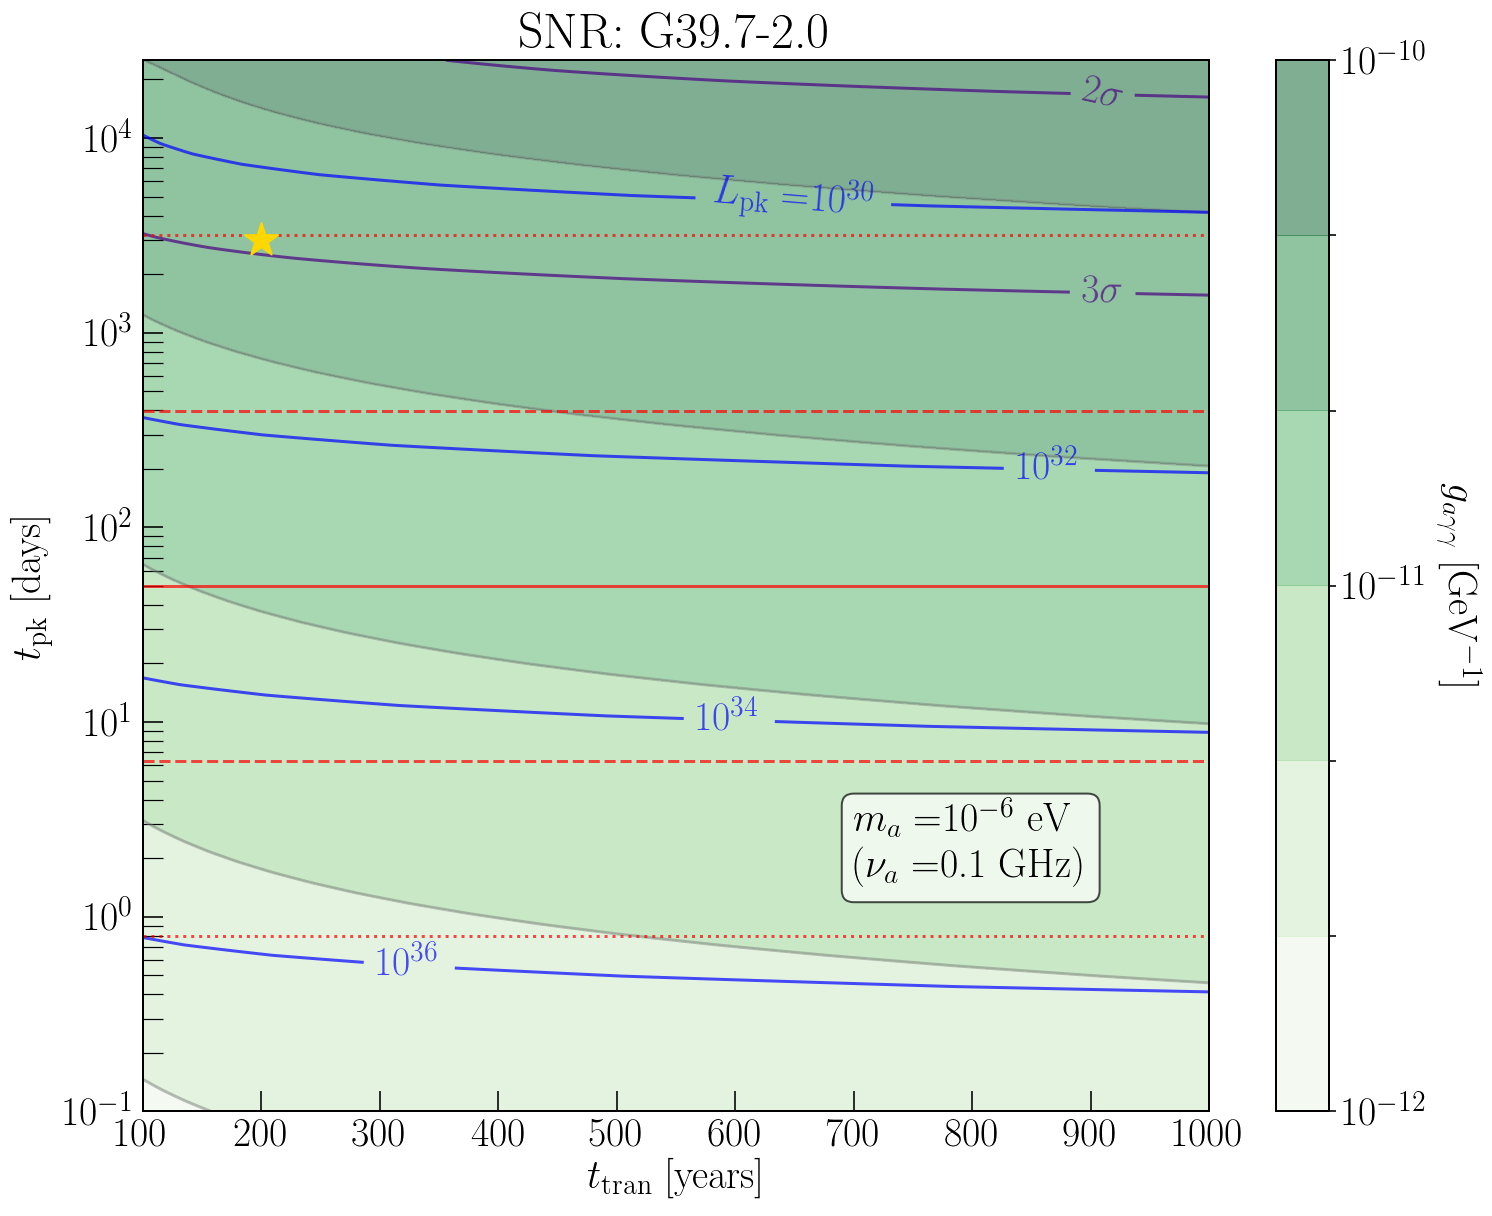

In [30]:
name = W50

sd_id = 20 # 19, 20, 21
if_id = sd_id+3

ttr, tpk, ga_reach, Lpk, sigs = ttr_tpk_results(name, sd_id, if_id)

lines, _, _ = gr.load_green_results(name, run_id=sd_id)
ma_idx = ['ma:' in line for line in lines].index(True)
ma = float(lines[ma_idx].split()[-1])

del lines, ma_idx

# Setting up plot

plt.rcParams['axes.linewidth'] = 1.
plt.rc('font', family='serif', size=25)
fig, ax = plt.subplots(figsize=(11, 9))

fs = 20  # fontsize
label_size = 20 # fontsize of labels

ga_min, ga_max = np.ceil(log10(ga_reach.min()))-1, np.floor(log10(ga_reach.max()))+1
decades = int(3*(ga_max - ga_min)+1)

ga_levels = 10.**(np.linspace(ga_min, ga_max, decades))
cs = ax.contourf(ttr, tpk, ga_reach, levels=ga_levels, locator=ticker.LogLocator(), alpha=0.5, cmap=plt.cm.Greens)
cbar = fig.colorbar(cs)
cbar.set_label(r"$g_{a\gamma\gamma}\ [\mathrm{GeV^{-1}}]$", rotation=270, labelpad=25, fontsize=label_size)
cbar.ax.tick_params(labelsize=20)
ax.contour(ttr, tpk, ga_reach, levels=ga_levels, locator=ticker.LogLocator(), alpha=0.5, colors=['grey'])

cs2 = ax.contour(ttr, tpk, Lpk, colors=['blue'], locator=ticker.LogLocator(), alpha=0.7)
# inline labeling
fmt = {}

strs = []
for i, lvl in enumerate(cs2.levels):
    if lvl == 1.e30:
        strs.append(r"$L_{\rm pk} = $"+float_exp(lvl))
    else:
        strs.append(float_exp(lvl))

for l, s in zip(cs2.levels, strs):
    fmt[l] = s
plt.clabel(cs2, cs2.levels, inline=True, fmt=fmt, fontsize=20)



cs3 = ax.contour(ttr, tpk, sigs, colors=['indigo'], levels=range(4), alpha=0.7)
# inline labeling
fmt = {}
strs = ['mean', r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
for l, s in zip(cs3.levels, strs):
    fmt[l] = s
plt.clabel(cs3, cs3.levels, inline=True, fmt=fmt, fontsize=20)



for ns in range(-2,3):
    val = 10.**(ct._mu_log10_tpk_ + ns*ct._sig_log10_tpk_)
    if ns in [-2, 2]:
        ls = ":"
    elif ns in [-1, 1]:
        ls = "--"
    else:
        ls = "-"
    ax.axhline(val, ls=ls, color='r', alpha=0.7)

del val

ax.scatter(200., 3000., s=300., zorder=25, marker='*', color="gold")

plt.yscale('log');
plt.xscale('linear');
plt.xlabel(r'$t_{\rm tran}$ [years]', fontsize=label_size)
plt.ylabel(r'$t_{\rm pk}$ [days]', fontsize=label_size);

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(700, 1.5, r"$m_a = $%s eV" % float_exp(ma)+"\n"+r"($\nu_a = $%.1f GHz)" % pt.nu_from_ma(ma), fontsize=20, bbox=props)

ax.set_title("SNR: %s" % name, fontsize=25);

ax.set_xticks(np.arange(100, 1100, 100))
ax.tick_params("both", which="both", labelsize=fs, direction="in", length=10.)

plt.tight_layout()

file_name = "ttr-tpk_reach_%s.pdf" % name.replace(".", "")
plt.savefig("../plots/"+file_name, bbox_inches="tight")

del ma

In [31]:
def Lpk_fn(t_tr, t_pk):
    
    return 10.**interp2d(log10(ttr), log10(tpk), log10(Lpk))(log10(t_tr), log10(t_pk))

In [32]:
[Lpk_fn(tt, 3000) for tt in [100, 200, 300]]

[array([4.73914958e+30]), array([3.33012426e+30]), array([2.75146641e+30])]

### 3.4 $(m_a, g_{a\gamma\gamma})$; w/ uncertainties

In [33]:
dt.snrs_dct[W50].__dict__

{'no_dist': False,
 'no_flux': False,
 'is_complete': False,
 'is_spectral_certain': False,
 'is_flux_certain': False,
 'is_type_certain': False,
 'name': 'G39.7-2.0',
 'l': 39.7,
 'b': -2.0,
 'ang_size': 84.8528137423857,
 'sr': 0.0004784858509023251,
 'snu_at_1GHz': 85.0,
 'alpha': 0.7,
 'distance': 4.9,
 'age': 54772.25575051661,
 'radius': 60.47257332493333}

In [34]:
dt.snr_ages.loc[dt.name_expand(W50)]

age_min (yr)     30000.000000
age_max (yr)    100000.000000
geom_mean        54772.255751
arith_mean       65000.000000
Name: G039.7-02.0, dtype: float64

In [35]:
params = ['age', 'distance', 'alpha', 'trans']
vary = {}
snr = dt.snrs_dct[W50]

for param in params:
    
    if param == 'age':
        # arXiv:1202.0245
        age_DF = dt.snr_ages.loc[dt.name_expand(W50)]
        vary[param] = [snr.get_age(), age_DF['age_min (yr)'], age_DF['age_max (yr)']]
    
    elif param == 'distance':
        # 0707.0506, 0803.0642, 7 1307.8427
        vary[param] = [snr.get_distance(), 4.5, 5.5]
    
    elif param == 'alpha':
        # 1802.03406
        vary[param] = [snr.get_spectral_index(), 0.5, 0.8]
    
    elif param == 'trans':
        vary[param] = [200., 100., 300.]
        
del snr

In [36]:
vary

{'age': [54772.25575051661, 30000.0, 100000.0],
 'distance': [4.9, 4.5, 5.5],
 'alpha': [0.7, 0.5, 0.8],
 'trans': [200.0, 100.0, 300.0]}

In [37]:
folder = "../output/green_snr/"
ma_arr = np.loadtxt(folder+"ma_arr.txt", delimiter=",")
ga_ref = 1.e-10
# Maximum number of steps:
max_steps = 1000001
modes = ["single dish", "interferometry"]

In [38]:
def vary_routine(name, vary_param, sn_th=1., include_free=False, t_peak=(10**(ct._mu_log10_tpk_)), L_peak=None, t_extra=0.):
    
    if include_free:
        raise ValueError("The keyword argument include_free==True is not currently supported.")
    
    # lightcurve parameters
    lightcurve_params = {'use_free_expansion': include_free,
                         't_peak':t_peak}
    
    # data dictionary
    data = {'deltaE_over_E': ct._deltaE_over_E_,
            'f_Delta': ct._f_Delta_,
            'exper': 'SKA',
            'total_observing_time': 100.,
            'verbose': 0,
            'DM_profile': 'NFW',
            'average': True}
    
    # SNR object
    snr = dt.SuperNovaRemnant()
    
    # SNR dictionary
    snr.__dict__ = {key:val for key, val in dt.snrs_cut[name].__dict__.items()}
    
    # parameters to be varies:
    to_vary = vary[vary_param]
    
    # parameters to be fixed...
    to_fix = {key:value[0] for key, value in vary.items() if key != vary_param}
    
    # ... that are part of the SNR dictionary:
    snr_fix = {key:value for key, value in to_fix.items() if key in snr.__dict__.keys()}
    
    # ... or part of lightcurve_params:
    lc_fix = {'t_'+key:value for key, value in to_fix.items() if key in ['age', 'trans']}
    
    # updating SNR params:
    snr.__dict__.update(snr_fix)
    
    # updating  lightcurve_params:
    lightcurve_params.update(lc_fix)
    
    maga_dict = {}
    for SKA_mode in modes:
        
        data.update({'correlation_mode': SKA_mode})
        maga_dict[SKA_mode] = []
        
        for val in to_vary:
            
#             print(val)
            
            if vary_param == 'age':
                t_age = val
                lightcurve_params.update({'t_age':t_age})
                snr.__dict__.update({'age':t_age})
            
            elif vary_param == 'trans':
                t_trans = val
                lightcurve_params.update({'t_trans': t_trans})
            
            else:
                # for distance & alpha, only update SNR dictionary
                snr.__dict__.update({vary_param:val})
            
            # Reading some important SNR properties:
            alpha = snr.get_spectral_index() # spectral index
            gamma = snr.get_gamma() # Sedov-Taylor analytic formula
            L0 = snr.get_luminosity() # [cgs]
            age = snr.get_age() # [years]
            radius = snr.get_radius()
            
            lightcurve_params.update({'L_today': L0})
            
            # Reading some important lightcurve properties:
            t_age = lightcurve_params['t_age']
            t_trans = lightcurve_params['t_trans']
        
            if not bool(int(np.round(t_age/age))):
                raise ValueError("Age was not updated accordingly!")
            
            # Computing L_peak
            _, computed_pars = ap.L_source(t_age, model='eff',
                                            output_pars=True,
                                            gamma=gamma,
                                            t_peak=t_peak,
                                            t_trans=t_trans,
                                            L_today=L0,
                                            t_age=t_age)
            
            L_peak = computed_pars['L_peak']
            del computed_pars
            
            # Snu kwargs
            age_steps = abs(int(1000*(log10(t_age) - log10(t_peak/365.)) + 1))
            snu_echo_kwargs = {'tmin_default': None,
                               'Nt': min(age_steps, max_steps),
                               'xmin': ct._au_over_kpc_,
                               'xmax_default': 100.,
                               'use_quad': False,
                               'lin_space': False,
                               'Nint': min(age_steps, max_steps),
                               't_extra_old': t_extra}
            
            # Performing routine
            z, new_output = md.snr_routine(ma_arr, ga_ref,
                                           snr,
                                lightcurve_params=lightcurve_params,
                                snu_echo_kwargs=snu_echo_kwargs,
                                           data=data,
                                           output_all=True)
            
            # Keeping echo's spectral irradiance
            signal_Snu = new_output['signal_Snu']
            del new_output
            
            # Regularizing the signal-to-noise ratio:
            reg_z = np.nan_to_num(z)
            reg_z = np.where(reg_z < ct._zero_, ct._zero_, reg_z) # converting 0s to a small number
            
            # Finding reach
            ga_reach = ec.ga_reach(sn_th, reg_z, ga_ref)
            ga_reach = np.nan_to_num(ga_reach)
            
            maga_dict[SKA_mode].append(ga_reach)
    
    # putting both modes together:
    maga_vals = []
    for i, val in enumerate(to_vary):
        ma_ga = np.vstack((ma_arr, np.minimum.reduce((maga_dict["single dish"][i], maga_dict["interferometry"][i])))).T
        maga_vals.append(ma_ga)
    
    return maga_vals

../routines.py:329: RuntimeWarning: invalid value encountered in true_divide
  area_dish = area/number_of_dishes
../routines.py:395: RuntimeWarning: invalid value encountered in true_divide
  new_output['noise_power']


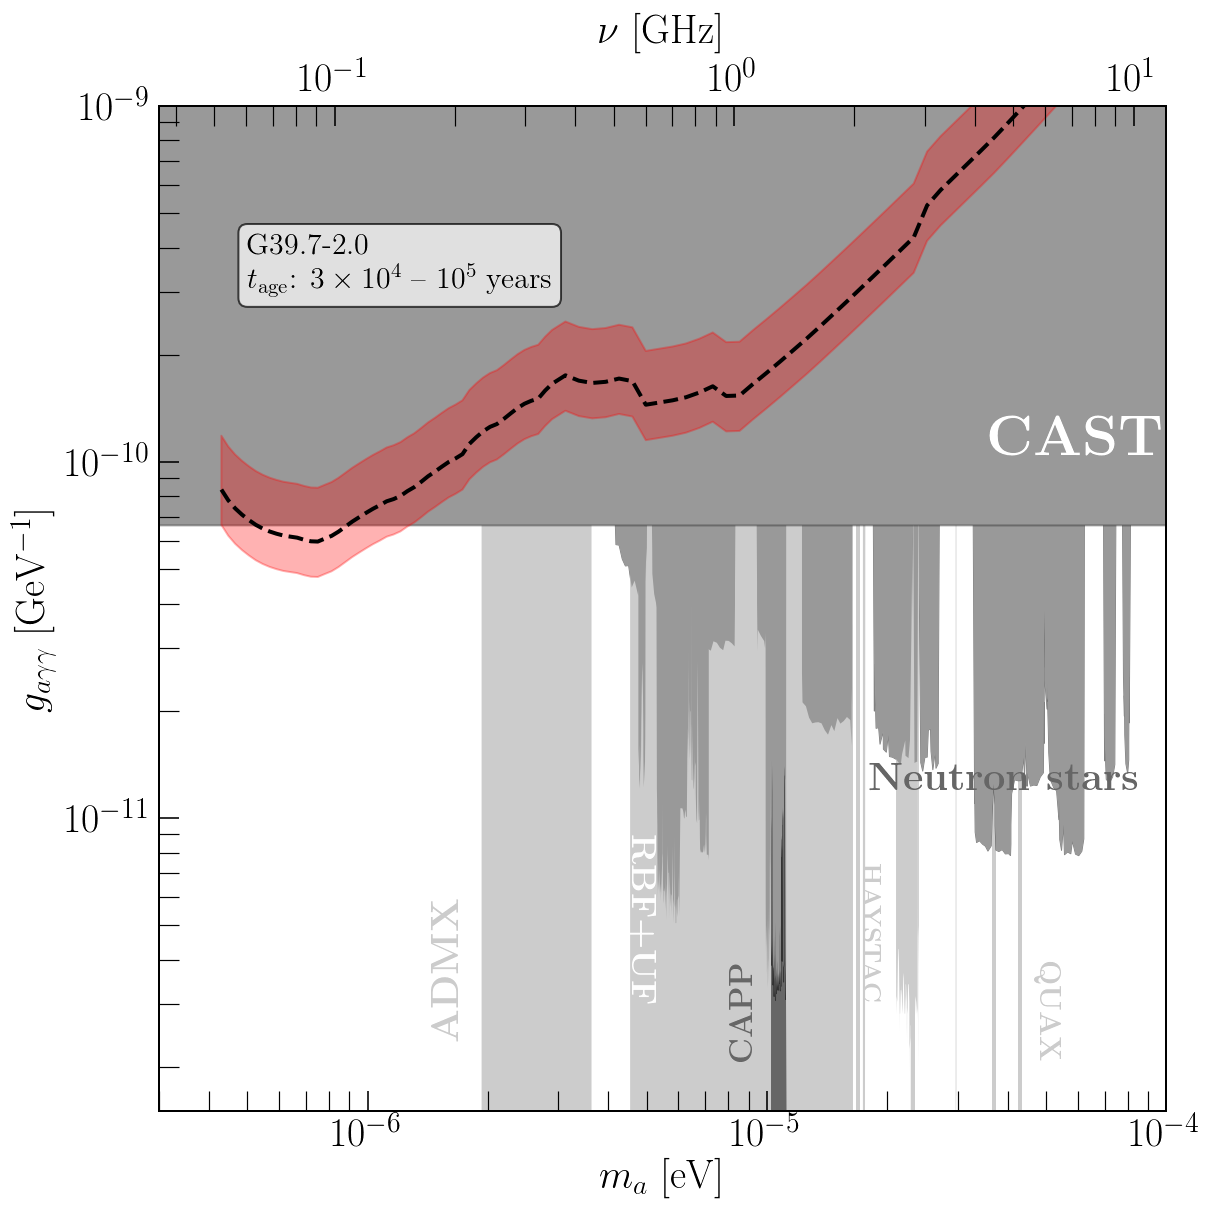

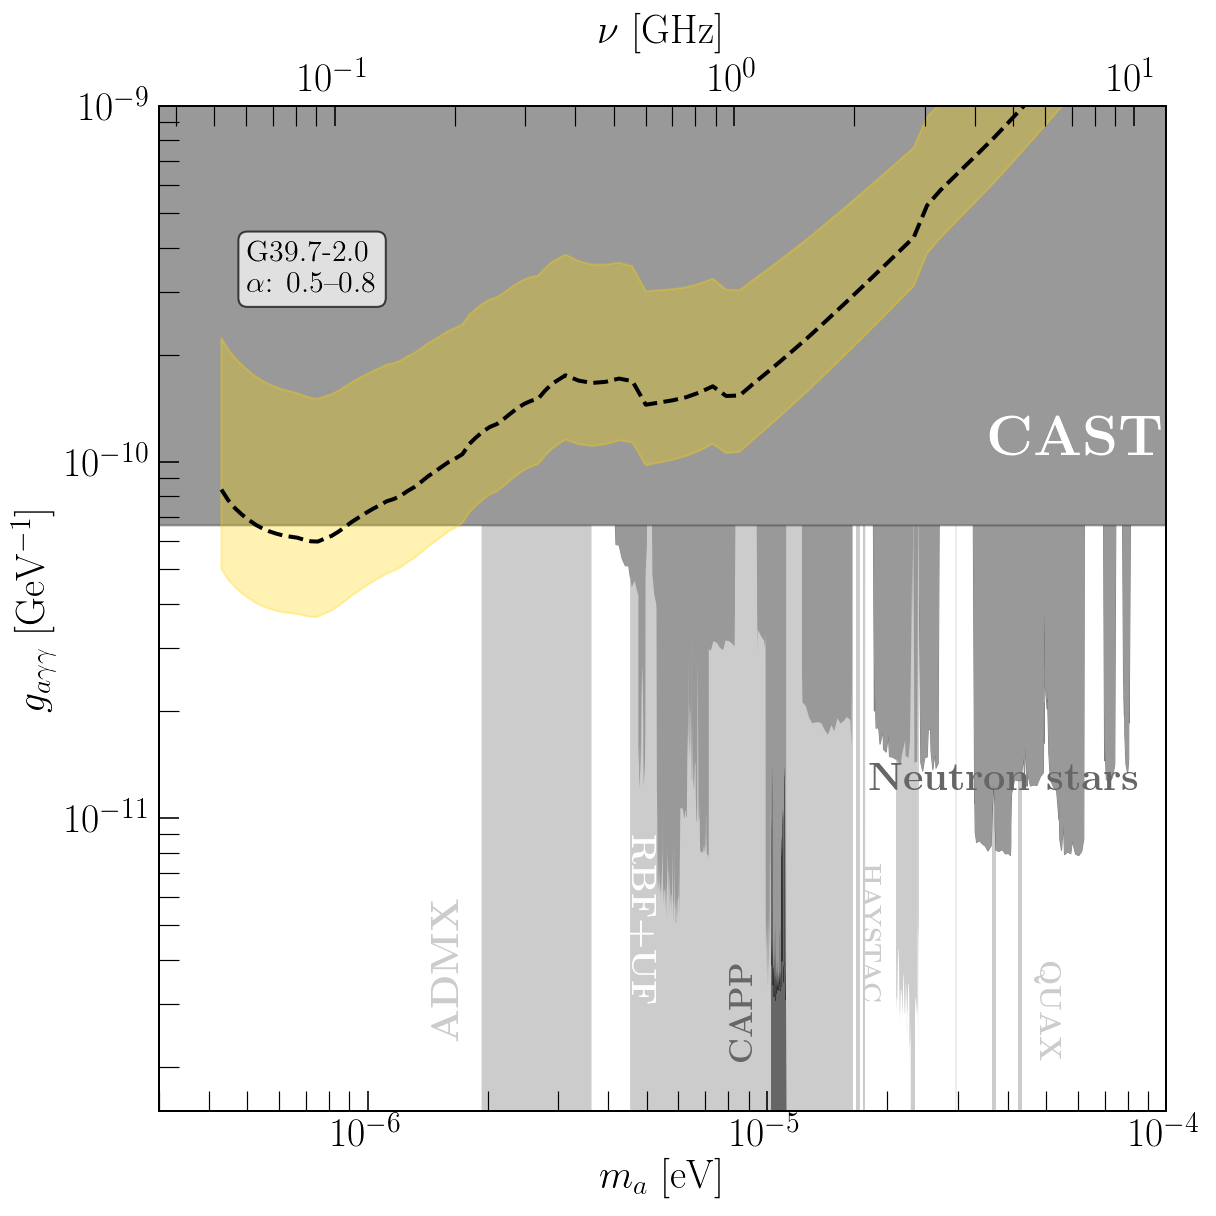

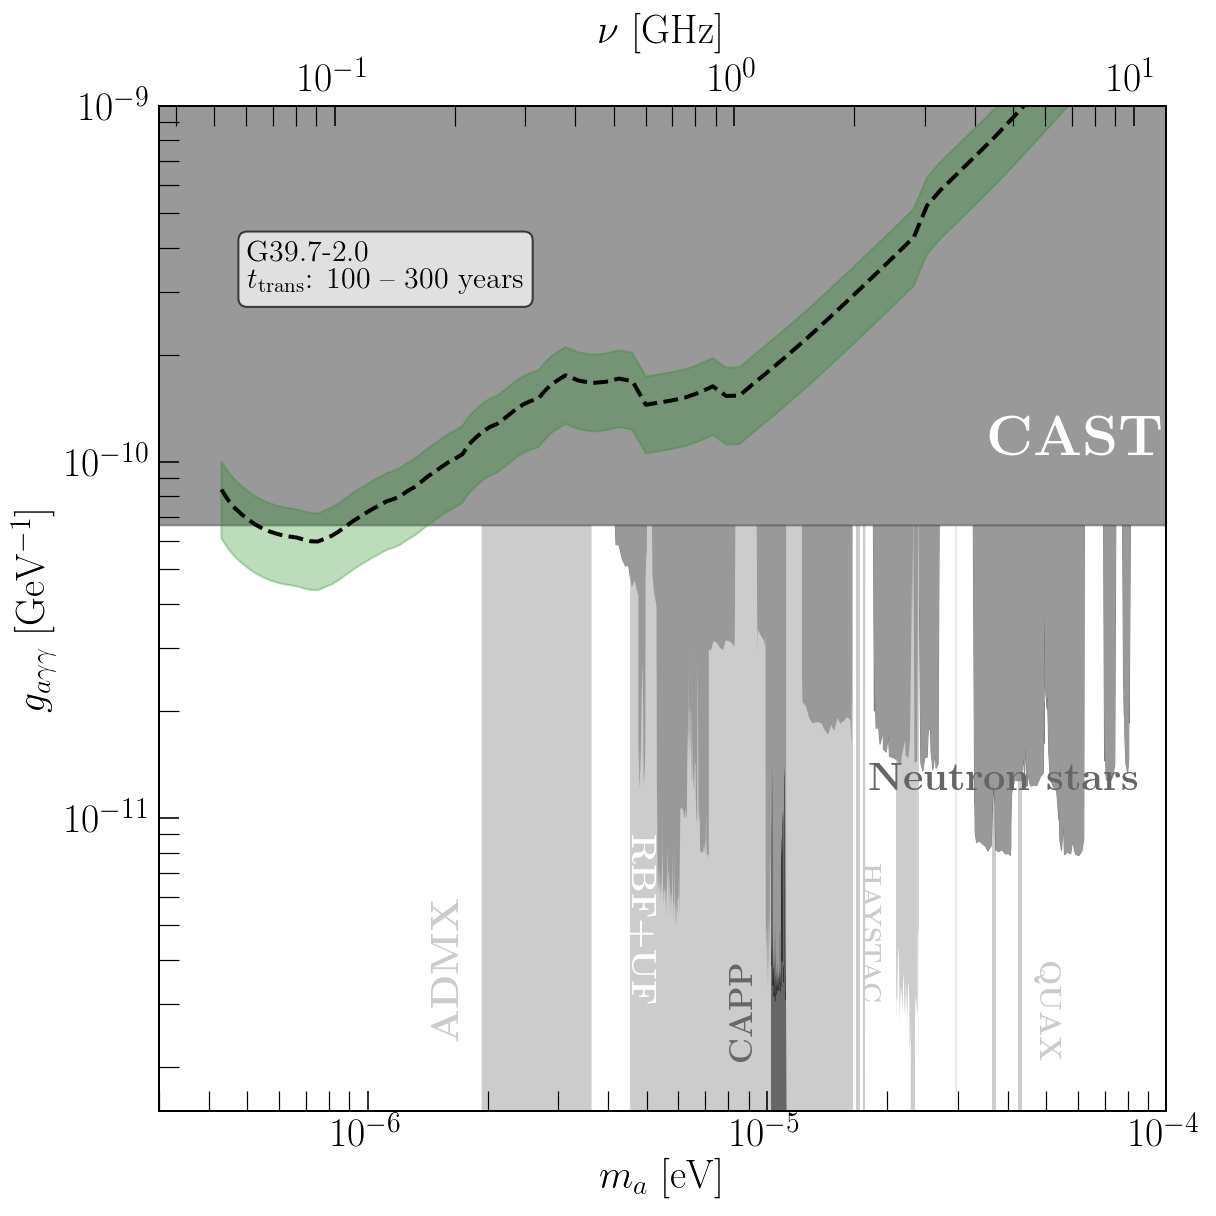

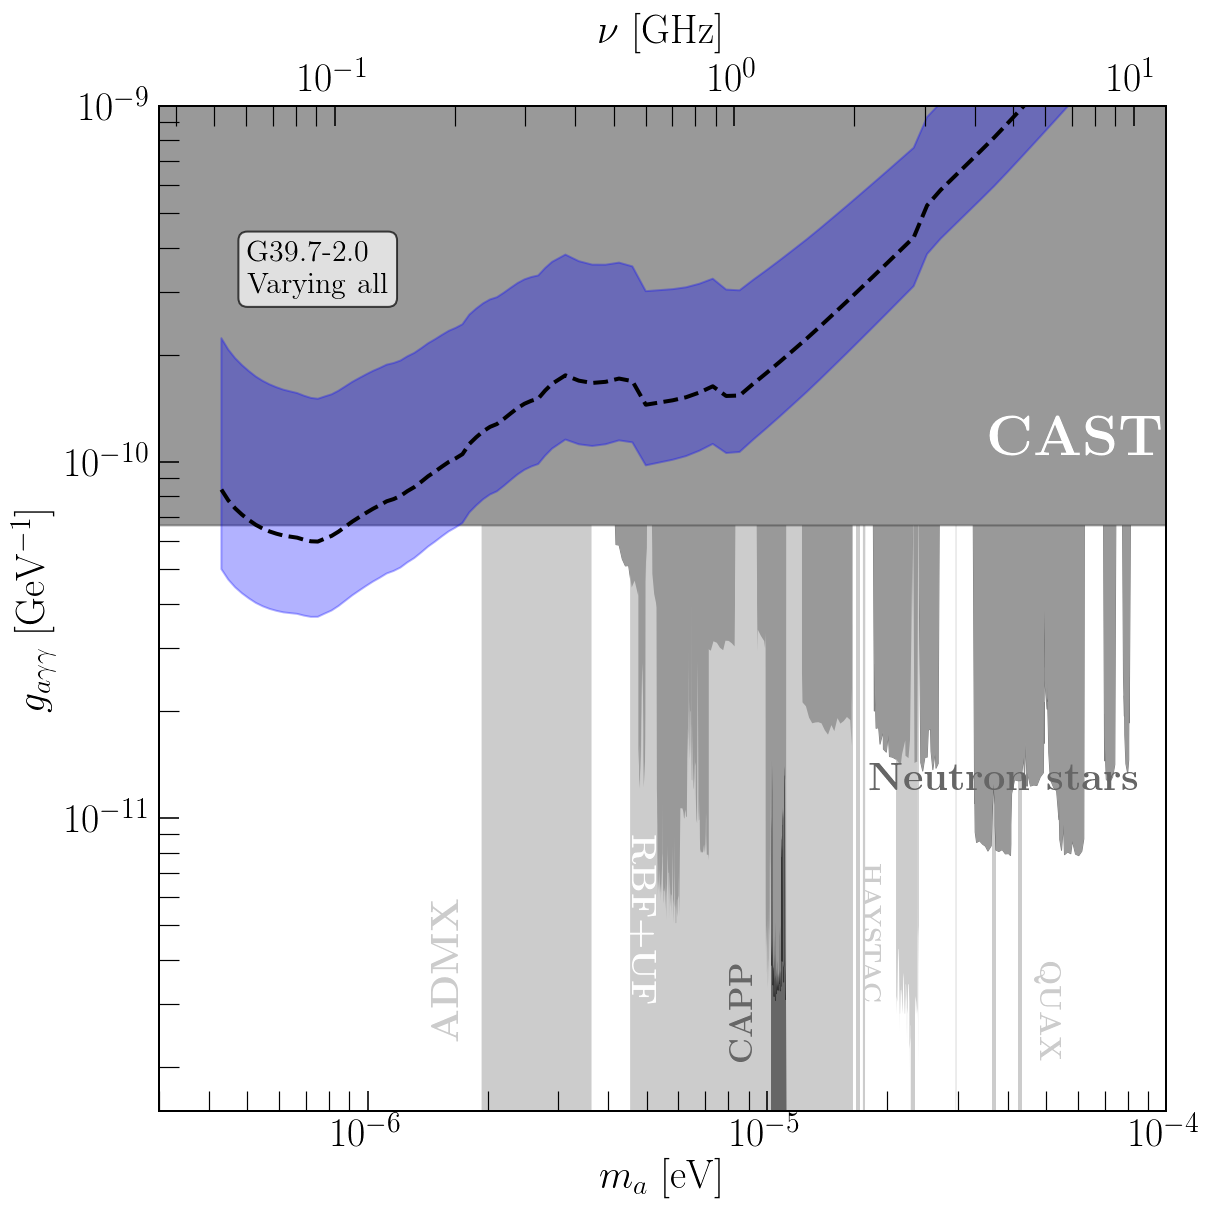

In [43]:
name = W50
lw = 2.

def par_col(param):
    if param == 'age':
        return "red"
    elif param == 'alpha':
        return "gold"
    elif param == 'trans':
        return "forestgreen"
    elif param == 'all':
        return "blue"

def par_leg(param):
    if param == 'age':
        return r"$t_{\rm age}$: %s $\mbox{--}$ %s years" % (float_exp(vary[param][1]), float_exp(vary[param][2]))
    elif param == 'alpha':
        return r"$\alpha$: $%s \mbox{--} %s$" % (vary[param][1], vary[param][2])
    elif param == 'trans':
        return r"$t_{\rm trans}$: $%s$ $\mbox{--}$ $%s$ years" % (int(vary[param][1]), int(int(vary[param][2])))
    elif param == 'all':
        return "Varying all"

param_results = {}
for param in vary.keys():
    if param == 'distance':
        continue
    param_results[param] = vary_routine(name, param)


for param in vary.keys():
    if param == 'distance':
        continue
    
    fig, ax = gen_constraints()
    
    results = param_results[param]
    
    ax.loglog(results[0][:,0], results[0][:,1], lw=lw, color="k", ls="--", zorder=51)
    ax.fill_between(results[0][:,0], results[1][:,1], results[2][:,1], alpha=0.3, color=par_col(param), zorder=50)
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(5.e-7, 3.e-10, ("%s" % name)+"\n"+par_leg(param), fontsize=15, bbox=props)
    
    plt.tight_layout()
    
    file_name = "ma_ga_reach_%s_%s.pdf" % (name.replace(".", ""), param)
    plt.savefig("../plots/"+file_name, bbox_inches="tight")


# all params
all_options = list(itertools.product(*[list(range(3)), param_results.keys()]))
mid_res = [param_results[param][0][:,1] for param in param_results.keys()]
each_res = [param_results[param][i][:,1] for i, param in all_options]

all_mid = np.vstack((ma_arr, np.minimum.reduce(mid_res))).T
all_lo = np.vstack((ma_arr, np.minimum.reduce(each_res))).T
all_hi = np.vstack((ma_arr, np.maximum.reduce(each_res))).T

fig, ax = gen_constraints()

ax.loglog(all_mid[:,0], all_mid[:,1], lw=lw, color="k", ls="--", zorder=51)
ax.fill_between(all_mid[:,0], all_lo[:,1], all_hi[:,1], alpha=0.3, color=par_col("all"), zorder=50)

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(5.e-7, 3.e-10, ("%s" % name)+"\n"+par_leg("all"), fontsize=15, bbox=props)

plt.tight_layout()    
file_name = "ma_ga_reach_%s_all.pdf" % name.replace(".", "")
plt.savefig("../plots/"+file_name, bbox_inches="tight")